# Setup environment

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from pytz import timezone
import copy
import pathlib

from sklearn.metrics import mean_squared_error, mean_absolute_error, root_mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split

from src.lightgbm_wrapper.feature_engineer import add_time_features, add_lag_features, add_rolling_features
from src.lightgbm_wrapper.plot import plot_1_data, plot_2_data
from src.lightgbm_wrapper.model import build_supervised_for_horizon, train_test_validation_split, train_lgbm_for_horizon, plot_timeseries_example

try:
    import lightgbm as lgb
except:
    print("lightgbm is not installed")

DATA_DIR = "/le_thanh_van_118/workspace/hiep_workspace/air_quality_index_project/dataset/merged-data/by-station"
STATION_IDS = [211, 212, 213, 214, 215, 216]

CMAQDATA_DIR = "/le_thanh_van_118/workspace/hiep_workspace/air_quality_index_project/dataset/concentration_station"

PM_COLS = [
    "NO2_quantrac",
    "PM25_quantrac",
    "O3_quantrac",
    "CO_quantrac",
    "Temperature_quantrac",
    "Humid_quantrac",
    "SO2_quantrac"
]

CMAQ_COLS = [
    "NO2_cmaq",
    "O3_cmaq",
    "SO2_cmaq"
]

BASE_FEATURE_COLS = PM_COLS + CMAQ_COLS

# Define lag and rolling windows for feature engineering
LAG_STEPS = [3, 6, 12, 24]
ROLL_WINDOWS = [3, 6, 12, 24]

# Define horizon (= n_past = n_future)
HORIZONS = [1, 24, 48, 72]

RANDOM_STATE = 42

# Directory to save the results and meta data
LIGHTGBM_DIR = f"/le_thanh_van_118/workspace/hiep_workspace/lightgbm_results/{datetime.now(timezone('Asia/Saigon')).strftime('%Y_%m_%d-%H_%M_%S')}"
pathlib.Path(LIGHTGBM_DIR).mkdir(parents=True, exist_ok=True)
print(LIGHTGBM_DIR)
with open(os.path.join(LIGHTGBM_DIR, "CONFIGURATIONS.txt"), "w") as f:
    f.write(f"BASE_FEATURE_COLS: {BASE_FEATURE_COLS}\n")
    f.write(f"LAG_STEPS: {LAG_STEPS}\n")
    f.write(f"ROLL_WINDOWS: {ROLL_WINDOWS}\n")
    f.write(f"HORIZONS: {HORIZONS}\n")
    f.write(f"RANDOM_STATE: {RANDOM_STATE}\n")

/le_thanh_van_118/workspace/hiep_workspace/lightgbm_results/2025_12_17-18_48_15


# Load dataset

## Method

In [2]:
def load_station_csv(station_id, data_dir=DATA_DIR):
    csv_path = os.path.join(data_dir, f"{station_id}.csv")
    df = pd.read_csv(csv_path)

    # Convert to datetime
    if "date" in df.columns:
        df["date"] = pd.to_datetime(df["date"])
    elif "Date" in df.columns and "Time" in df.columns:
        df["date"] = pd.to_datetime((df["Date"] + " " + df["Time"]).astype('datetime64[ns]'), format="%y/%m/%d %H:%M:%S")
        df = df.drop(columns=["Date", "Time"])
    df = df.sort_values("date").reset_index(drop=True)

    # Remove "Unnamed" column
    for c in df.columns:
        if "Unnamed:" in c:
            df = df.drop(columns=[c])

    # Add station_id column
    if "Station" not in df.columns:
        df["station_id"] = station_id
    else:
        df = df.rename({"Station": "station_id"}, axis=1)
    return df

## CMAQ data

In [3]:
# Load dataset
dfs_cmaq = []
for sid in STATION_IDS:
    df_sid = load_station_csv(sid, CMAQDATA_DIR)
    dfs_cmaq.append(df_sid)
df_cmaq = pd.concat(dfs_cmaq, ignore_index=True)

# Rename columns
df_cmaq = df_cmaq.rename({c: f"{c}_cmaq" for c in df_cmaq.columns if c not in ["date", "station_id"]}, axis=1)

# Sort data by station then date
df_cmaq = df_cmaq.sort_values(["station_id", "date"]).reset_index(drop=True)

# Remove uncessary features
df_cmaq = df_cmaq.loc[:, ["date"] + CMAQ_COLS + ["station_id"]]

display(df_cmaq)

# Convert unit
df_cmaq["NO2_cmaq"] = df_cmaq["NO2_cmaq"] * 1883.2
df_cmaq["O3_cmaq"] = df_cmaq["O3_cmaq"] * 1960
df_cmaq["SO2_cmaq"] = df_cmaq["SO2_cmaq"] * 2620

print(df_cmaq.shape)
print(df_cmaq.columns)
df_cmaq

,date,NO2_cmaq,O3_cmaq,SO2_cmaq,station_id
0,2022-01-01 07:00:00,0.000072,0.096425,0.000027,211
1,2022-01-01 08:00:00,0.000074,0.077419,0.000038,211
2,2022-01-01 09:00:00,0.000055,0.061006,0.000050,211
3,2022-01-01 10:00:00,0.000040,0.048525,0.000057,211
4,2022-01-01 11:00:00,0.000034,0.029449,0.000047,211
...,...,...,...,...,...
44851,2022-12-31 01:00:00,0.002276,0.026421,0.000149,216
44852,2022-12-31 02:00:00,0.002208,0.026171,0.000148,216
44853,2022-12-31 03:00:00,0.002249,0.026087,0.000151,216
44854,2022-12-31 04:00:00,0.002680,0.026347,0.000166,216


(44856, 5)
Index(['date', 'NO2_cmaq', 'O3_cmaq', 'SO2_cmaq', 'station_id'], dtype='object')


,date,NO2_cmaq,O3_cmaq,SO2_cmaq,station_id
0,2022-01-01 07:00:00,0.136344,188.993157,0.071526,211
1,2022-01-01 08:00:00,0.138604,151.741122,0.100084,211
2,2022-01-01 09:00:00,0.104141,119.571595,0.130476,211
3,2022-01-01 10:00:00,0.075893,95.109490,0.149078,211
4,2022-01-01 11:00:00,0.063087,57.721016,0.122092,211
...,...,...,...,...,...
44851,2022-12-31 01:00:00,4.285888,51.784937,0.389183,216
44852,2022-12-31 02:00:00,4.157322,51.295325,0.386550,216
44853,2022-12-31 03:00:00,4.235773,51.130547,0.394695,216
44854,2022-12-31 04:00:00,5.047855,51.640614,0.435544,216


## PM data

In [4]:
# Load dataset
dfs_pm = []
for sid in STATION_IDS:
    df_sid = load_station_csv(sid, DATA_DIR)
    dfs_pm.append(df_sid)
df_pm = pd.concat(dfs_pm, ignore_index=True)

# Sort data by station then date
df_pm = df_pm.sort_values(["station_id", "date"]).reset_index(drop=True)

# Remove uncessary features
df_pm = df_pm.loc[:, ["date"] + PM_COLS + ["station_id"]]

print(df_pm.shape)
print(df_pm.columns)
df_pm

(92966, 9)
Index(['date', 'NO2_quantrac', 'PM25_quantrac', 'O3_quantrac', 'CO_quantrac',
       'Temperature_quantrac', 'Humid_quantrac', 'SO2_quantrac', 'station_id'],
      dtype='object')


,date,NO2_quantrac,PM25_quantrac,O3_quantrac,CO_quantrac,Temperature_quantrac,Humid_quantrac,SO2_quantrac,station_id
0,2021-02-23 21:00:00,112.740762,15.604762,55.431381,90.000000,28.361905,63.188095,NaN,211
1,2021-02-23 22:00:00,112.366471,14.594118,58.197176,1200.603529,28.320588,63.773529,NaN,211
2,2021-02-23 23:00:00,112.700433,13.436667,55.029433,1177.897000,28.336667,64.205000,NaN,211
3,2021-02-24 00:00:00,112.480867,12.365000,54.767700,90.000000,28.305000,64.735000,NaN,211
4,2021-02-24 01:00:00,114.331500,11.636667,53.786200,90.000000,28.300000,65.188333,NaN,211
...,...,...,...,...,...,...,...,...,...
92961,2022-12-31 19:00:00,0.088233,41.450000,75.916667,2.087167,27.690000,67.290000,0.105667,216
92962,2022-12-31 20:00:00,0.083217,50.530000,66.116667,2.006500,27.401667,68.026667,0.104167,216
92963,2022-12-31 21:00:00,0.084300,55.055000,55.133333,2.418833,27.603333,66.965000,0.130167,216
92964,2022-12-31 22:00:00,0.066650,26.078333,46.750000,1.481500,27.036667,63.361667,0.075833,216


## Merge 2 data

In [5]:
dfs_all = []
for station in STATION_IDS:
    df_pm_station = df_pm[df_pm["station_id"] == station]
    df_cmaq_station = df_cmaq[df_cmaq["station_id"] == station]
    df_joined = pd.merge(df_pm_station.drop(columns=["station_id"]), df_cmaq_station, on='date', how='inner')
    dfs_all.append(df_joined)
df_all = pd.concat(dfs_all, axis=0).reset_index(drop=True)
df_all

,date,NO2_quantrac,PM25_quantrac,O3_quantrac,CO_quantrac,Temperature_quantrac,Humid_quantrac,SO2_quantrac,NO2_cmaq,O3_cmaq,SO2_cmaq,station_id
0,2022-01-01 07:00:00,90.000000,22.783333,35.588975,756.627400,24.661667,73.355000,NaN,0.136344,188.993157,0.071526,211
1,2022-01-01 08:00:00,90.000000,21.883333,55.011077,749.102000,27.258333,65.521667,NaN,0.138604,151.741122,0.100084,211
2,2022-01-01 09:00:00,90.000000,16.233333,64.729197,727.519000,29.250000,57.910000,NaN,0.104141,119.571595,0.130476,211
3,2022-01-01 10:00:00,90.000000,15.700000,75.109218,721.196900,30.676667,53.673333,NaN,0.075893,95.109490,0.149078,211
4,2022-01-01 11:00:00,74.207348,15.650000,77.767804,722.056400,32.168333,49.080000,NaN,0.063087,57.721016,0.122092,211
...,...,...,...,...,...,...,...,...,...,...,...,...
43370,2022-12-31 01:00:00,0.049037,17.709259,31.425926,0.824074,26.659259,64.601852,0.031852,4.285888,51.784937,0.389183,216
43371,2022-12-31 02:00:00,0.063288,22.803390,43.220339,0.717627,25.771186,66.067797,0.024746,4.157322,51.295325,0.386550,216
43372,2022-12-31 03:00:00,0.069050,23.031667,48.866667,0.746167,25.178333,68.278333,0.026167,4.235773,51.130547,0.394695,216
43373,2022-12-31 04:00:00,0.064600,22.331667,50.633333,0.617667,24.950000,68.225000,0.020333,5.047855,51.640614,0.435544,216


In [6]:
df_all.isnull().sum()

date                        0
NO2_quantrac            27391
PM25_quantrac           27393
O3_quantrac             30277
CO_quantrac             27407
Temperature_quantrac    35140
Humid_quantrac          35140
SO2_quantrac            28944
NO2_cmaq                    0
O3_cmaq                     0
SO2_cmaq                    0
station_id                  0
dtype: int64

# Data preparation

## Drop missing

Output: df_dropped

In [7]:
df_dropped = df_all.dropna().reset_index(drop=True)
df_dropped

,date,NO2_quantrac,PM25_quantrac,O3_quantrac,CO_quantrac,Temperature_quantrac,Humid_quantrac,SO2_quantrac,NO2_cmaq,O3_cmaq,SO2_cmaq,station_id
0,2022-01-01 07:00:00,0.081167,24.380000,60.100000,1.716167,25.045000,68.216667,0.100833,1.847962,192.197659,0.202002,216
1,2022-01-01 08:00:00,0.080950,22.648333,63.233333,2.143833,25.775000,66.696667,0.128833,2.436309,156.783693,0.274170,216
2,2022-01-01 09:00:00,0.077917,22.331667,66.700000,2.194833,27.061667,63.436667,0.132833,1.949658,125.387982,0.345334,216
3,2022-01-01 10:00:00,0.067467,24.293333,71.166667,1.860500,28.728333,58.321667,0.103667,1.540650,103.125890,0.342248,216
4,2022-01-01 11:00:00,0.038431,24.360345,53.982759,1.923966,32.191379,48.932759,0.124655,1.142447,86.564792,0.235276,216
...,...,...,...,...,...,...,...,...,...,...,...,...
6675,2022-12-31 01:00:00,0.049037,17.709259,31.425926,0.824074,26.659259,64.601852,0.031852,4.285888,51.784937,0.389183,216
6676,2022-12-31 02:00:00,0.063288,22.803390,43.220339,0.717627,25.771186,66.067797,0.024746,4.157322,51.295325,0.386550,216
6677,2022-12-31 03:00:00,0.069050,23.031667,48.866667,0.746167,25.178333,68.278333,0.026167,4.235773,51.130547,0.394695,216
6678,2022-12-31 04:00:00,0.064600,22.331667,50.633333,0.617667,24.950000,68.225000,0.020333,5.047855,51.640614,0.435544,216


## Update the STATION_IDS after dropping missing

In [8]:
STATION_IDS = list(df_dropped["station_id"].unique())
STATION_IDS

[216]

## Visualization

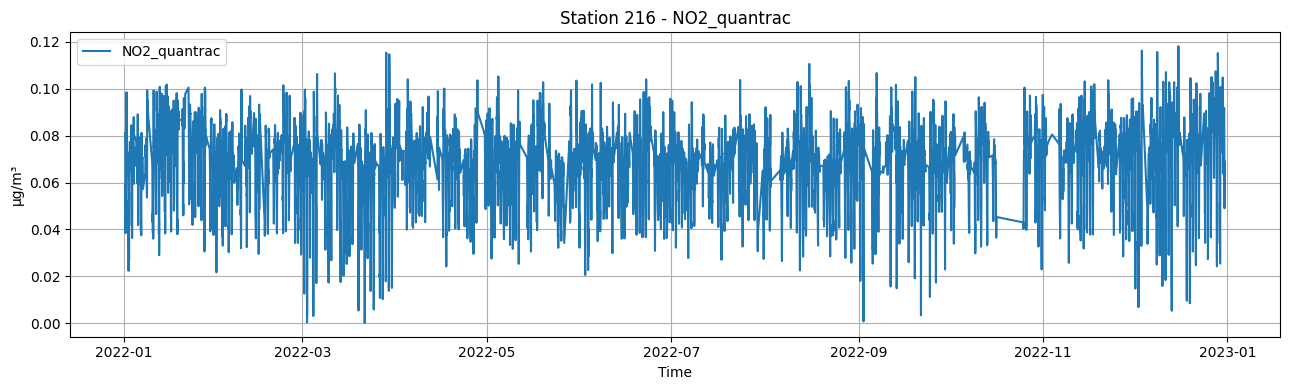

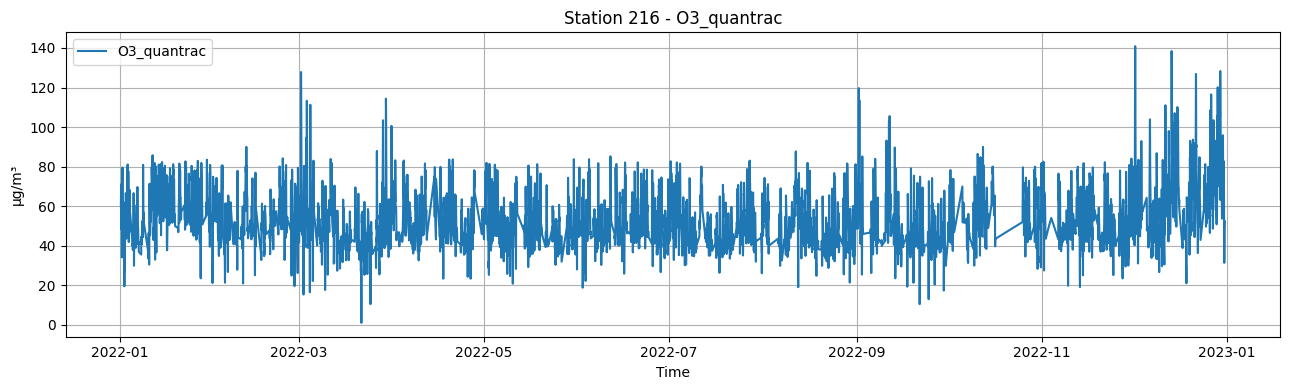

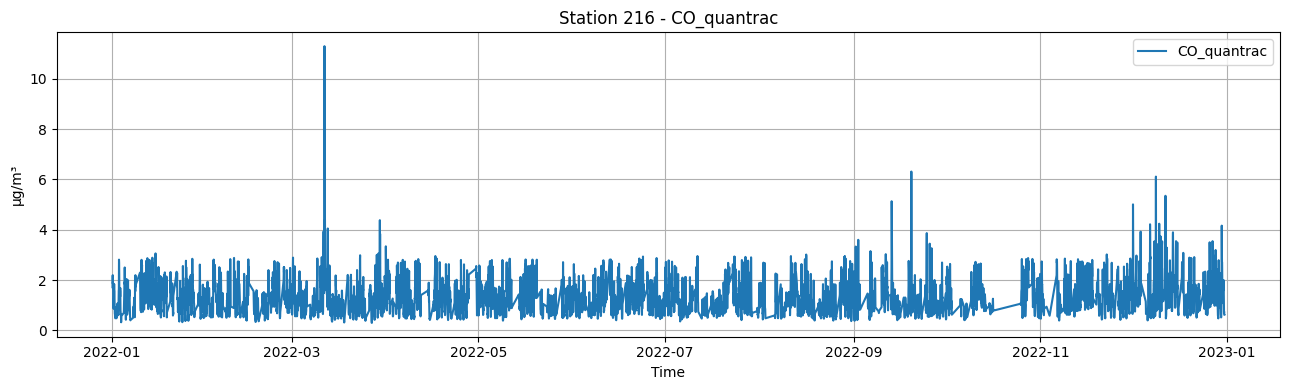

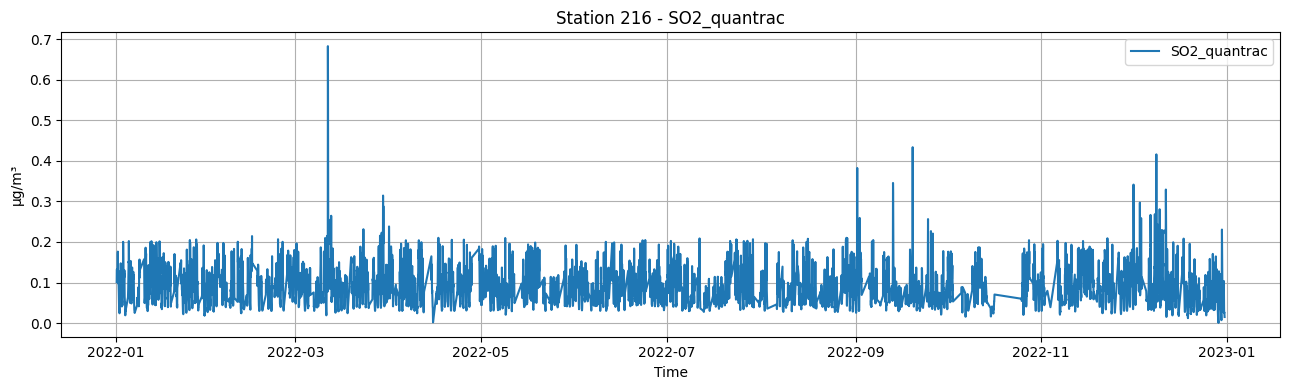

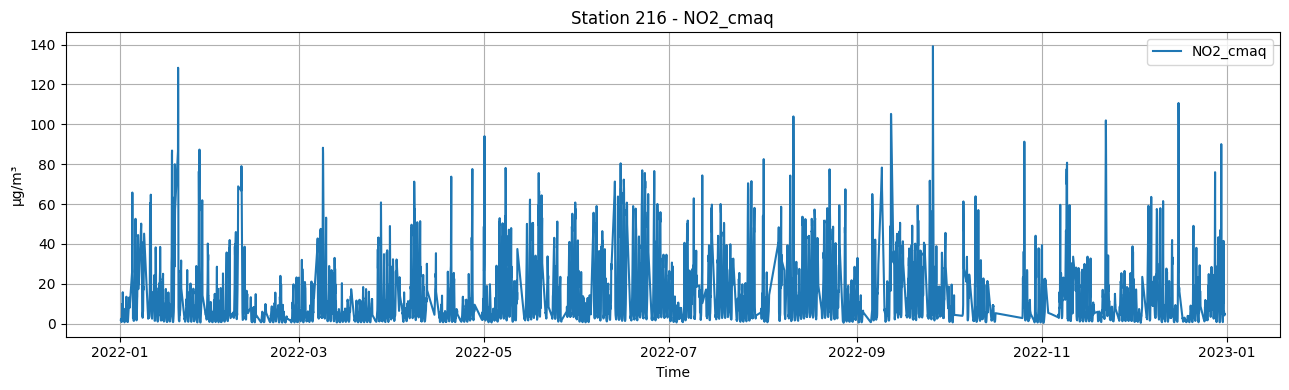

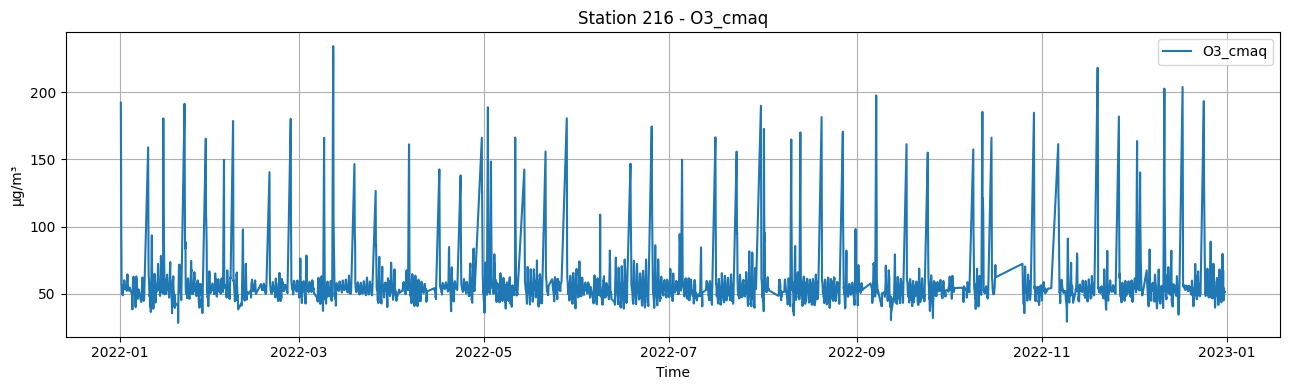

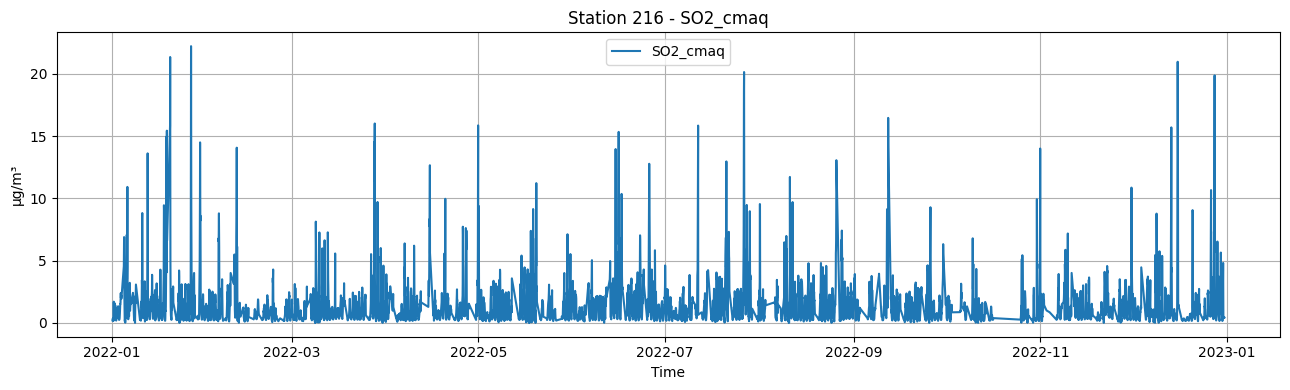

In [9]:
for station in STATION_IDS:
    df_station = df_dropped[df_dropped["station_id"] == station]
    for target_col in df_station.columns:
        if target_col not in ["date", "station_id", "Temperature_quantrac", "Humid_quantrac", "PM25_quantrac"]:
            plot_1_data(df_station, target_col, target_col, df_station["date"], f"Station {station} - {target_col}")
            #plot_1_data(df_station, target_col, target_col, df_station.index, f"Station {station} - {target_col}")
    print("\n" + "=" * 150 + "\n")

## Convert ppm to ug/m3

Apply only to station 216, year 2022 on NO2, CO columns

Output: df_converted

In [10]:
df_converted = copy.deepcopy(df_dropped)
mask = (df_converted["station_id"] == 216) & (df_converted["date"] >= "2022-01-01")
df_converted.loc[mask, "NO2_quantrac"] = df_converted.loc[mask, "NO2_quantrac"].apply(lambda x: x * 1883.2)
df_converted.loc[mask, "CO_quantrac"] = df_converted.loc[mask, "CO_quantrac"].apply(lambda x: x * 1146.8)
df_converted

,date,NO2_quantrac,PM25_quantrac,O3_quantrac,CO_quantrac,Temperature_quantrac,Humid_quantrac,SO2_quantrac,NO2_cmaq,O3_cmaq,SO2_cmaq,station_id
0,2022-01-01 07:00:00,152.853067,24.380000,60.100000,1968.099933,25.045000,68.216667,0.100833,1.847962,192.197659,0.202002,216
1,2022-01-01 08:00:00,152.445040,22.648333,63.233333,2458.548067,25.775000,66.696667,0.128833,2.436309,156.783693,0.274170,216
2,2022-01-01 09:00:00,146.732667,22.331667,66.700000,2517.034867,27.061667,63.436667,0.132833,1.949658,125.387982,0.345334,216
3,2022-01-01 10:00:00,127.053227,24.293333,71.166667,2133.621400,28.728333,58.321667,0.103667,1.540650,103.125890,0.342248,216
4,2022-01-01 11:00:00,72.373324,24.360345,53.982759,2206.403655,32.191379,48.932759,0.124655,1.142447,86.564792,0.235276,216
...,...,...,...,...,...,...,...,...,...,...,...,...
6675,2022-12-31 01:00:00,92.346548,17.709259,31.425926,945.048148,26.659259,64.601852,0.031852,4.285888,51.784937,0.389183,216
6676,2022-12-31 02:00:00,119.184217,22.803390,43.220339,822.974780,25.771186,66.067797,0.024746,4.157322,51.295325,0.386550,216
6677,2022-12-31 03:00:00,130.034960,23.031667,48.866667,855.703933,25.178333,68.278333,0.026167,4.235773,51.130547,0.394695,216
6678,2022-12-31 04:00:00,121.654720,22.331667,50.633333,708.340133,24.950000,68.225000,0.020333,5.047855,51.640614,0.435544,216


## Visualization after converting unit

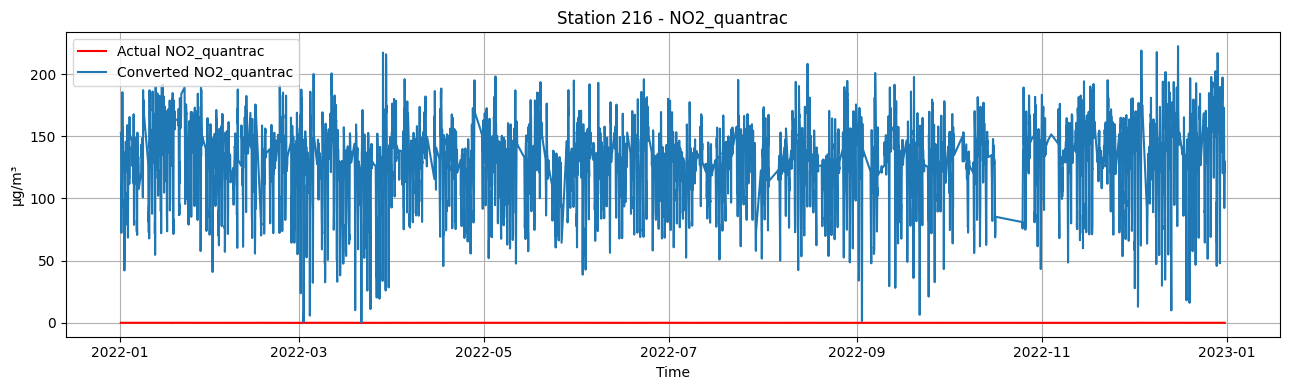

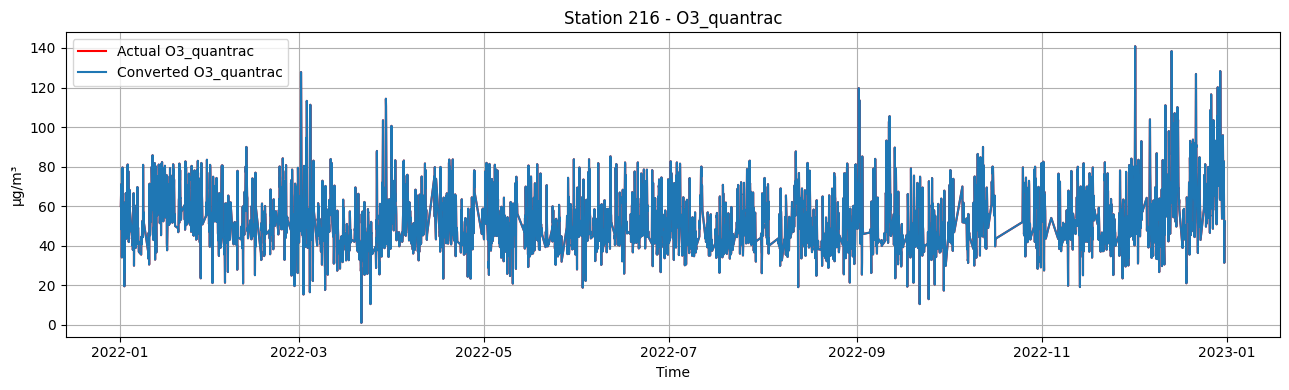

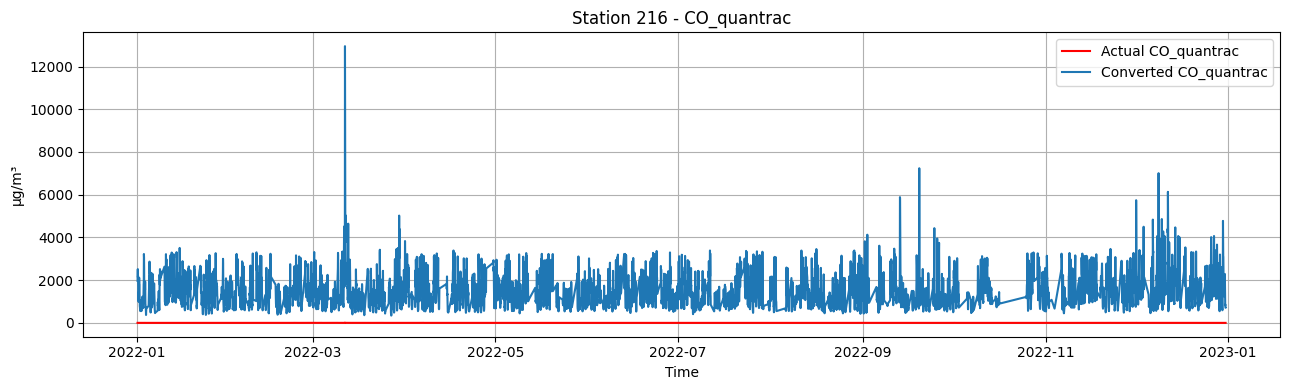

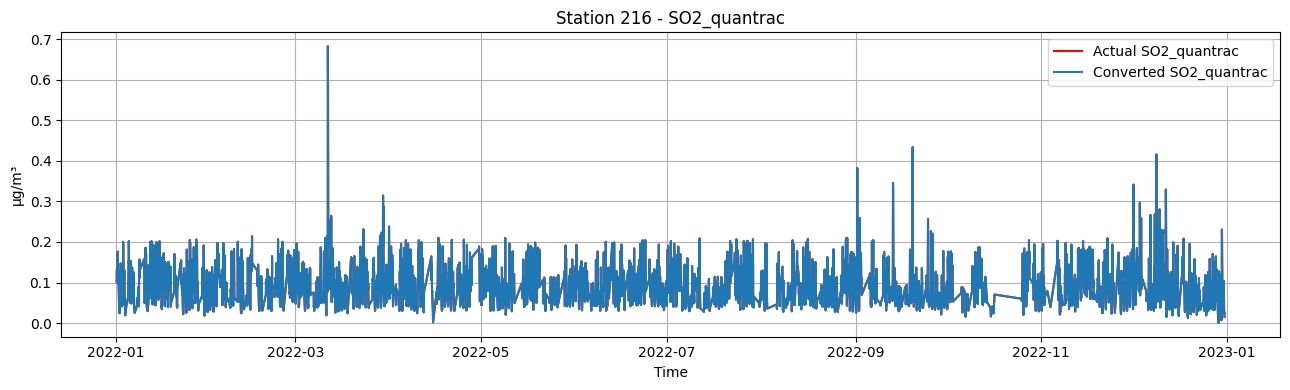

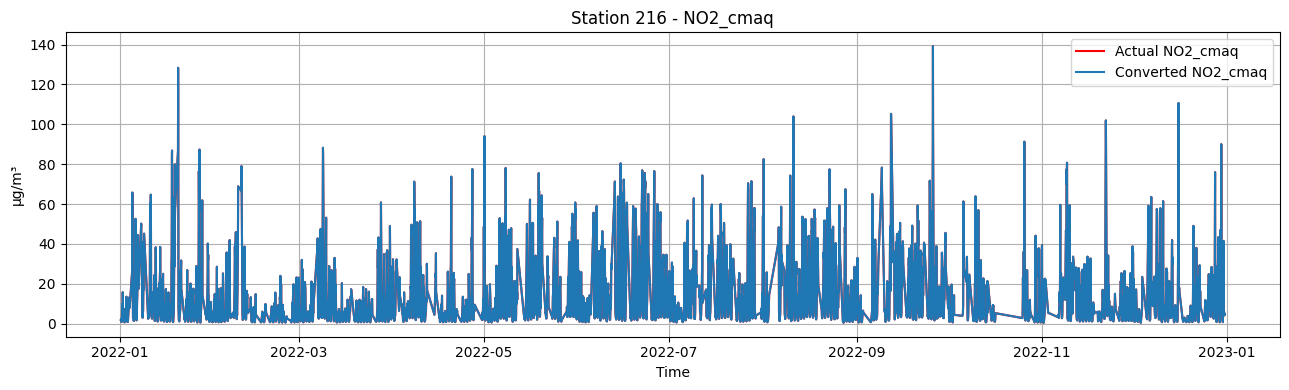

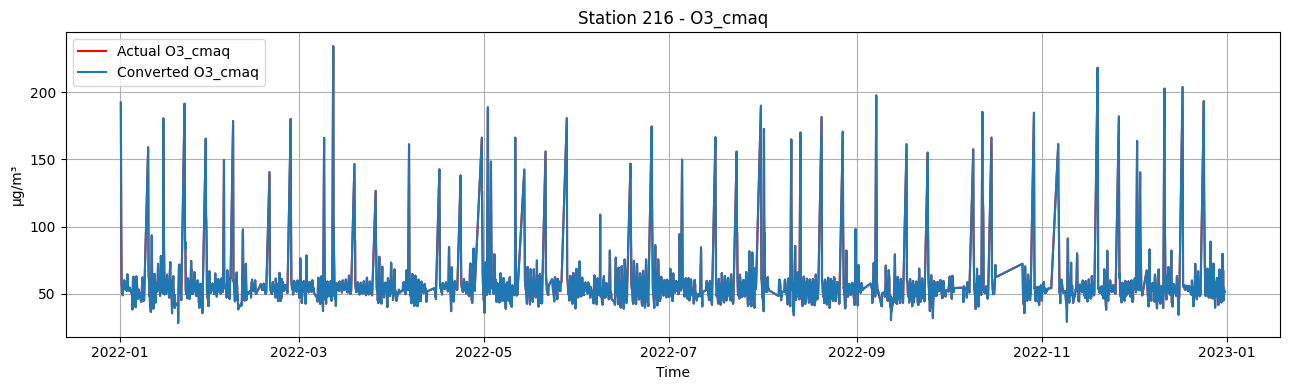

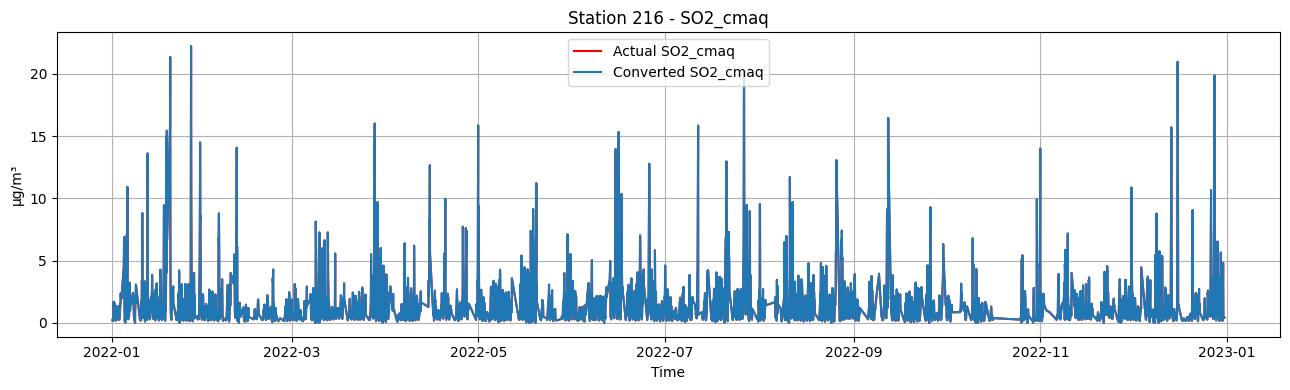

In [11]:
for station in STATION_IDS:
    df_station = df_dropped[df_dropped["station_id"] == station]
    df_station_converted = df_converted[df_converted["station_id"] == station]
    for target_col in df_station.columns:
        if target_col not in ["date", "station_id", "Temperature_quantrac", "Humid_quantrac", "PM25_quantrac"]:
            plot_2_data(df_station, target_col, f"Actual {target_col}",
                        df_station_converted, target_col, f"Converted {target_col}",
                        df_station["date"], f"Station {station} - {target_col}")
                        #df_station.index, f"Station {station} - {target_col}")
    print("\n" + "=" * 150 + "\n")

## Ugly hack to remove outliers

In [12]:
test = copy.deepcopy(df_converted)

lenbefore = len(test)
print(f"Before: {lenbefore} records")

# 212 CO quantrac
test212 = test[test["station_id"] == 212]
test = test.drop(index=test212[test212["CO_quantrac"] > 4000].index)

# 213 CO quantrac
test213 = test[test["station_id"] == 213]
test = test.drop(index=test213[test213["CO_quantrac"] > 4000].index)

# 214 CO quantrac
test214 = test[test["station_id"] == 214]
test = test.drop(index=test214[test214["CO_quantrac"] > 4000].index)

# 215 NO2 quantrac
# 215 CO quantrac
test215 = test[test["station_id"] == 215]
test = test.drop(index=test215[test215["NO2_quantrac"] > 140].index)
test = test.drop(index=test215[test215["CO_quantrac"] > 2500].index)

# 216 CO quantrac
test216 = test[test["station_id"] == 216]
test = test.drop(index=test216[test216["CO_quantrac"] > 10000].index)

lenafter = len(test)
print(f"After: {lenafter} records")
print(f"Removed {lenbefore - lenafter} records")

df_converted = test.reset_index(drop=True)

Before: 6680 records
After: 6678 records
Removed 2 records


## Visualization after removing outliers

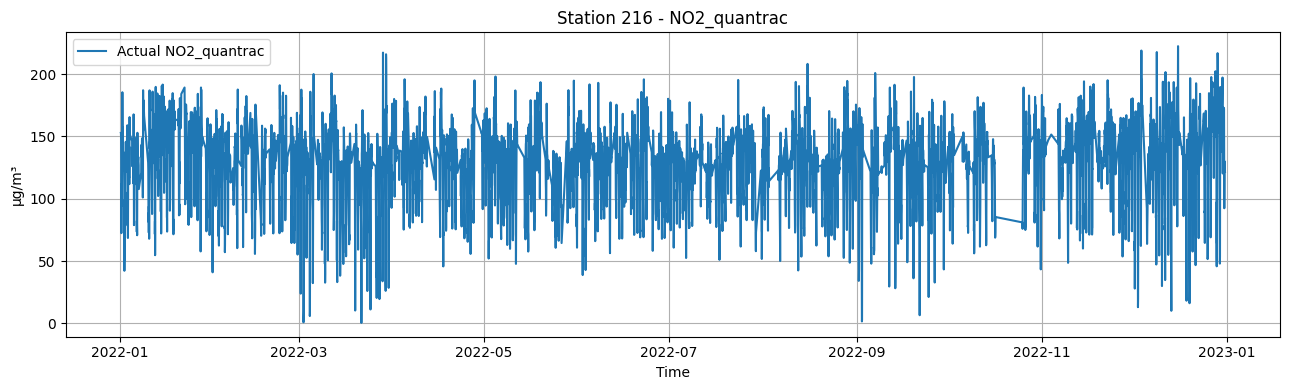

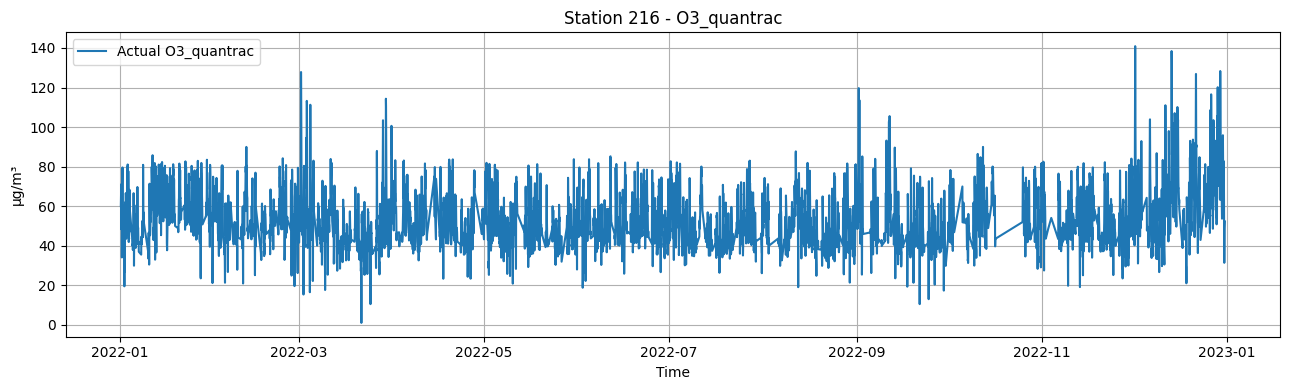

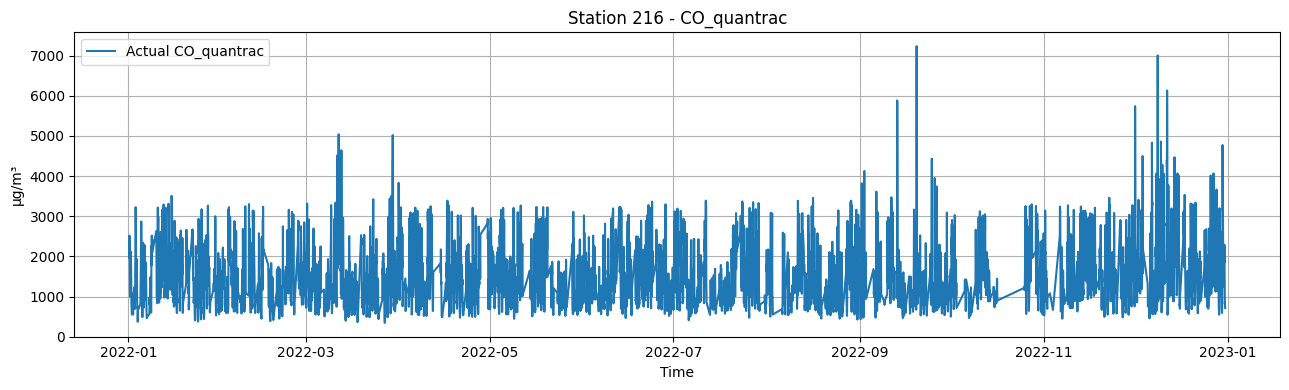

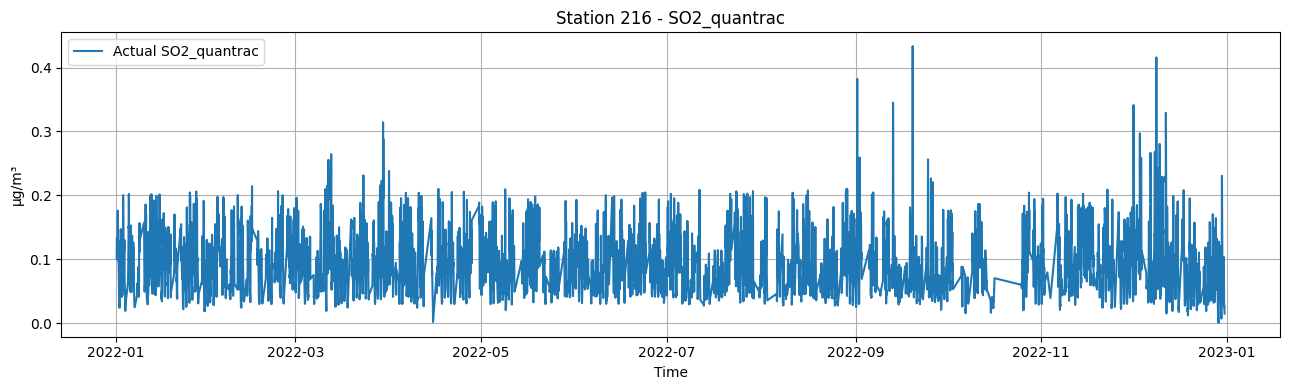

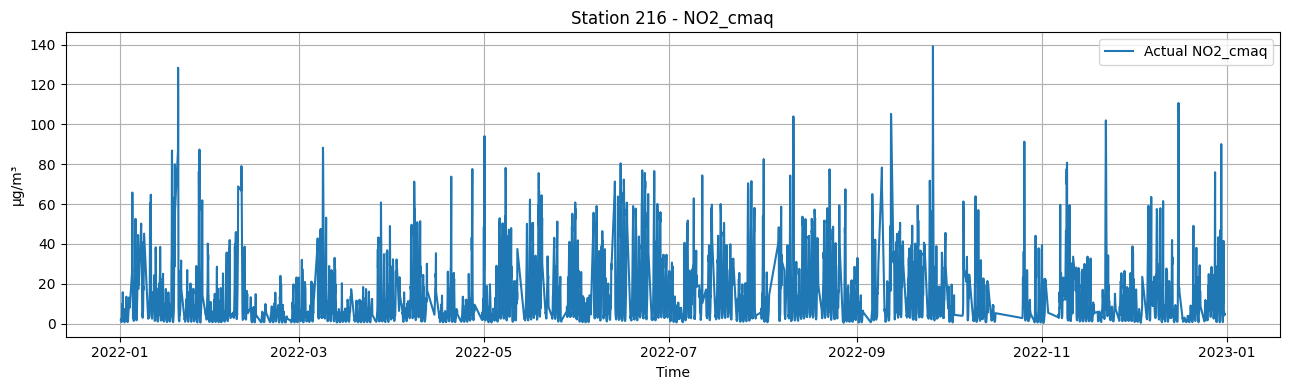

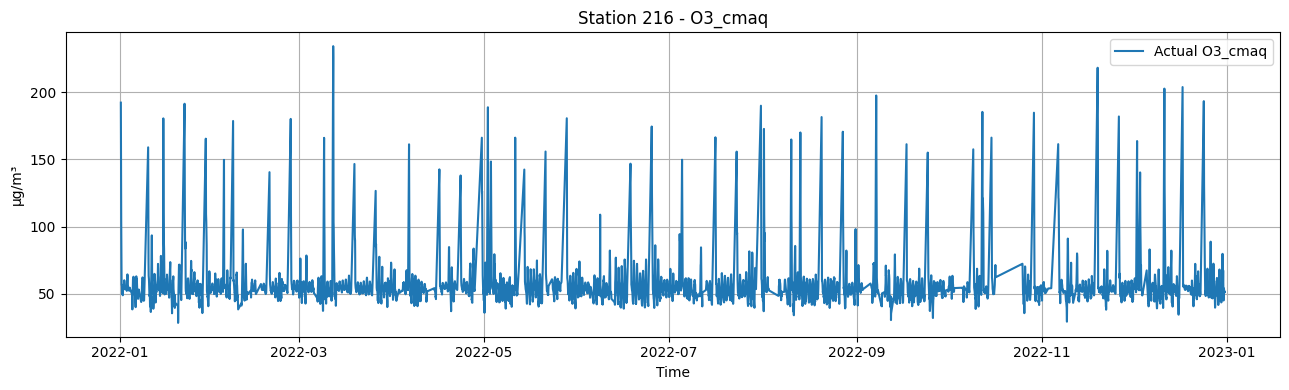

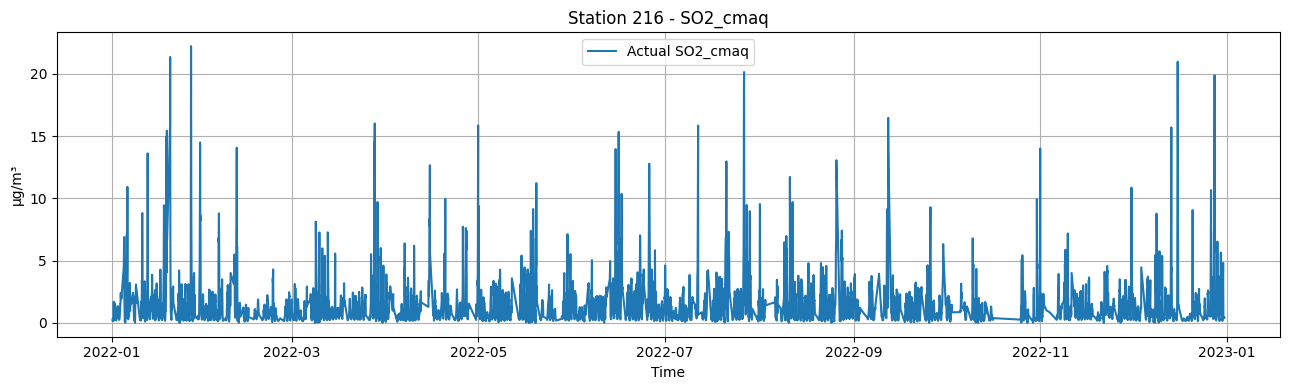

In [13]:
for station in STATION_IDS:
    df_station = df_converted[df_converted["station_id"] == station]
    for target_col in df_station.columns:
        if target_col not in ["date", "station_id", "Temperature_quantrac", "Humid_quantrac", "PM25_quantrac"]:
            plot_1_data(df_station, target_col, f"Actual {target_col}",
                        df_station["date"], f"Station {station} - {target_col}")
                        #df_station.index, f"Station {station} - {target_col}")
    print("\n" + "=" * 150 + "\n")

## Feature engineering

In [14]:
# Add time features and lag feature for all gases
dftestno2 = add_time_features(df_converted)
dftestno2 = add_lag_features(df_converted, group_col="station_id", target_cols=BASE_FEATURE_COLS, lag_steps=[3, 6, 12, 24])
dftestno2 = add_rolling_features(df_converted, group_col="station_id", target_cols=["NO2_quantrac"], windows=[3, 6, 12, 24])
print(dftestno2.shape)
print(dftestno2.columns)
dftestno2

(6678, 20)
Index(['date', 'NO2_quantrac', 'PM25_quantrac', 'O3_quantrac', 'CO_quantrac',
       'Temperature_quantrac', 'Humid_quantrac', 'SO2_quantrac', 'NO2_cmaq',
       'O3_cmaq', 'SO2_cmaq', 'station_id', 'NO2_quantrac_roll3_mean',
       'NO2_quantrac_roll3_std', 'NO2_quantrac_roll6_mean',
       'NO2_quantrac_roll6_std', 'NO2_quantrac_roll12_mean',
       'NO2_quantrac_roll12_std', 'NO2_quantrac_roll24_mean',
       'NO2_quantrac_roll24_std'],
      dtype='object')


,date,NO2_quantrac,PM25_quantrac,O3_quantrac,CO_quantrac,Temperature_quantrac,Humid_quantrac,SO2_quantrac,NO2_cmaq,O3_cmaq,SO2_cmaq,station_id,NO2_quantrac_roll3_mean,NO2_quantrac_roll3_std,NO2_quantrac_roll6_mean,NO2_quantrac_roll6_std,NO2_quantrac_roll12_mean,NO2_quantrac_roll12_std,NO2_quantrac_roll24_mean,NO2_quantrac_roll24_std
0,2022-01-01 07:00:00,152.853067,24.380000,60.100000,1968.099933,25.045000,68.216667,0.100833,1.847962,192.197659,0.202002,216,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2022-01-01 08:00:00,152.445040,22.648333,63.233333,2458.548067,25.775000,66.696667,0.128833,2.436309,156.783693,0.274170,216,152.853067,NaN,152.853067,NaN,152.853067,NaN,152.853067,NaN
2,2022-01-01 09:00:00,146.732667,22.331667,66.700000,2517.034867,27.061667,63.436667,0.132833,1.949658,125.387982,0.345334,216,152.649053,0.288518,152.649053,0.288518,152.649053,0.288518,152.649053,0.288518
3,2022-01-01 10:00:00,127.053227,24.293333,71.166667,2133.621400,28.728333,58.321667,0.103667,1.540650,103.125890,0.342248,216,150.676924,3.421914,150.676924,3.421914,150.676924,3.421914,150.676924,3.421914
4,2022-01-01 11:00:00,72.373324,24.360345,53.982759,2206.403655,32.191379,48.932759,0.124655,1.142447,86.564792,0.235276,216,142.076978,13.320759,144.771000,12.137797,144.771000,12.137797,144.771000,12.137797
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6673,2022-12-31 01:00:00,92.346548,17.709259,31.425926,945.048148,26.659259,64.601852,0.031852,4.285888,51.784937,0.389183,216,162.467849,16.160517,167.076458,11.438594,151.443282,20.588002,157.199778,20.786118
6674,2022-12-31 02:00:00,119.184217,22.803390,43.220339,822.974780,25.771186,66.067797,0.024746,4.157322,51.295325,0.386550,216,136.126298,40.487158,154.120158,32.318802,149.118635,25.435481,154.467975,24.639817
6675,2022-12-31 03:00:00,130.034960,23.031667,48.866667,855.703933,25.178333,68.278333,0.026167,4.235773,51.130547,0.394695,216,118.448157,25.741473,145.145079,33.472296,146.514295,26.848976,153.499776,25.572650
6676,2022-12-31 04:00:00,121.654720,22.331667,50.633333,708.340133,24.950000,68.225000,0.020333,5.047855,51.640614,0.435544,216,113.855242,19.401097,138.161545,31.048054,145.117588,27.265733,152.945279,25.944042


## Build supervised from time-series

In [15]:
# Example
Xdummy, ydummy = build_supervised_for_horizon(dftestno2, horizon_h=72, target_col="NO2_quantrac")
print("Horizon 1h:", Xdummy.shape, ydummy.shape)
print(Xdummy.columns)
print(ydummy.columns)
display(Xdummy)
display(ydummy)

Horizon 1h: (6604, 19) (6604, 3)
Index(['date', 'station_id', 'PM25_quantrac', 'O3_quantrac', 'CO_quantrac',
       'Temperature_quantrac', 'Humid_quantrac', 'SO2_quantrac', 'NO2_cmaq',
       'O3_cmaq', 'SO2_cmaq', 'NO2_quantrac_roll3_mean',
       'NO2_quantrac_roll3_std', 'NO2_quantrac_roll6_mean',
       'NO2_quantrac_roll6_std', 'NO2_quantrac_roll12_mean',
       'NO2_quantrac_roll12_std', 'NO2_quantrac_roll24_mean',
       'NO2_quantrac_roll24_std'],
      dtype='object')
Index(['date', 'station_id', 'NO2_quantrac_t_plus_72h'], dtype='object')


,date,station_id,PM25_quantrac,O3_quantrac,CO_quantrac,Temperature_quantrac,Humid_quantrac,SO2_quantrac,NO2_cmaq,O3_cmaq,SO2_cmaq,NO2_quantrac_roll3_mean,NO2_quantrac_roll3_std,NO2_quantrac_roll6_mean,NO2_quantrac_roll6_std,NO2_quantrac_roll12_mean,NO2_quantrac_roll12_std,NO2_quantrac_roll24_mean,NO2_quantrac_roll24_std
0,2022-01-01 09:00:00,216,22.331667,66.700000,2517.034867,27.061667,63.436667,0.132833,1.949658,125.387982,0.345334,152.649053,0.288518,152.649053,0.288518,152.649053,0.288518,152.649053,0.288518
1,2022-01-01 10:00:00,216,24.293333,71.166667,2133.621400,28.728333,58.321667,0.103667,1.540650,103.125890,0.342248,150.676924,3.421914,150.676924,3.421914,150.676924,3.421914,150.676924,3.421914
2,2022-01-01 11:00:00,216,24.360345,53.982759,2206.403655,32.191379,48.932759,0.124655,1.142447,86.564792,0.235276,142.076978,13.320759,144.771000,12.137797,144.771000,12.137797,144.771000,12.137797
3,2022-01-01 12:00:00,216,22.908333,48.333333,1527.728733,33.625000,45.271667,0.111667,0.817503,63.247973,0.170824,115.386406,38.528093,130.291465,34.040847,130.291465,34.040847,130.291465,34.040847
4,2022-01-01 13:00:00,216,28.223333,70.116667,1153.489667,34.278333,46.648333,0.103667,0.832625,56.665207,0.159558,95.843693,28.149493,123.260309,34.980657,123.260309,34.980657,123.260309,34.980657
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6599,2022-12-27 23:00:00,216,33.321667,74.233333,1633.998867,26.328333,72.273333,0.055000,59.889300,43.220554,19.342058,175.022516,8.106778,164.314431,13.193297,147.852124,21.787281,162.720373,23.374430
6600,2022-12-28 00:00:00,216,29.511667,76.966667,1122.526067,25.923333,75.600000,0.033167,75.965866,39.656935,19.869703,174.781884,8.519693,166.412107,11.862084,149.159902,22.348334,162.637983,23.362139
6601,2022-12-28 01:00:00,216,36.455000,71.900000,1250.967667,25.563333,78.383333,0.041833,30.314140,41.167530,4.664907,168.263920,11.260467,168.033751,9.469346,151.461591,21.762316,161.247815,22.494585
6602,2022-12-28 02:00:00,216,53.257407,65.388889,2324.818444,25.151852,79.572222,0.090556,6.613904,44.155574,0.802737,161.955200,3.029911,168.488858,9.010355,155.094598,19.205420,159.987117,21.515841


,date,station_id,NO2_quantrac_t_plus_72h
0,2022-01-01 09:00:00,216,138.572133
1,2022-01-01 10:00:00,216,140.926133
2,2022-01-01 11:00:00,216,140.831973
3,2022-01-01 12:00:00,216,135.150987
4,2022-01-01 13:00:00,216,140.078693
...,...,...,...
6599,2022-12-27 23:00:00,216,92.346548
6600,2022-12-28 00:00:00,216,119.184217
6601,2022-12-28 01:00:00,216,130.034960
6602,2022-12-28 02:00:00,216,121.654720


## Split train/validation/test for each station

In [16]:
# Example
(X_train_dummy, y_train_dummy, meta_train_dummy,
 X_val_dummy, y_val_dummy, meta_val_dummy,
 X_test_dummy, y_test_dummy, meta_test_dummy) = train_test_validation_split(Xdummy, ydummy)
display(X_test_dummy)

,PM25_quantrac,O3_quantrac,CO_quantrac,Temperature_quantrac,Humid_quantrac,SO2_quantrac,NO2_cmaq,O3_cmaq,SO2_cmaq,NO2_quantrac_roll3_mean,NO2_quantrac_roll3_std,NO2_quantrac_roll6_mean,NO2_quantrac_roll6_std,NO2_quantrac_roll12_mean,NO2_quantrac_roll12_std,NO2_quantrac_roll24_mean,NO2_quantrac_roll24_std
5613,16.905000,41.616667,2169.363333,26.231667,94.508333,0.129167,7.664134,59.761239,0.745196,144.891316,6.007111,150.581087,8.614717,148.539177,7.447143,140.211667,11.279129
5614,19.085000,47.166667,2978.621867,27.033333,90.061667,0.170167,2.736450,66.583446,0.459155,144.253120,6.322291,148.814649,9.281174,148.369165,7.591408,141.348126,9.837897
5615,14.083333,46.150000,2427.202200,28.890000,80.045000,0.139333,2.774031,75.919355,0.470617,146.753591,4.958729,145.911382,5.153970,148.471172,7.564553,142.331575,9.141731
5616,11.178333,44.866667,1825.514467,30.341667,75.125000,0.108333,2.794396,85.499343,0.508309,137.682844,11.959281,141.287080,9.339836,146.993383,10.213483,141.940549,9.712366
5617,12.308333,42.400000,1549.135667,31.895000,70.036667,0.094167,2.072558,91.054865,0.661275,127.220622,18.679269,135.736871,15.575184,144.330748,14.748784,141.042106,11.523420
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6599,33.321667,74.233333,1633.998867,26.328333,72.273333,0.055000,59.889300,43.220554,19.342058,175.022516,8.106778,164.314431,13.193297,147.852124,21.787281,162.720373,23.374430
6600,29.511667,76.966667,1122.526067,25.923333,75.600000,0.033167,75.965866,39.656935,19.869703,174.781884,8.519693,166.412107,11.862084,149.159902,22.348334,162.637983,23.362139
6601,36.455000,71.900000,1250.967667,25.563333,78.383333,0.041833,30.314140,41.167530,4.664907,168.263920,11.260467,168.033751,9.469346,151.461591,21.762316,161.247815,22.494585
6602,53.257407,65.388889,2324.818444,25.151852,79.572222,0.090556,6.613904,44.155574,0.802737,161.955200,3.029911,168.488858,9.010355,155.094598,19.205420,159.987117,21.515841


# LightGBM model

## Define model

## Add time and lags features

In [17]:
# Add time features and lag feature for all gases
df_time_feats = add_time_features(df_converted)
df_lag_feats = add_lag_features(df_time_feats, group_col="station_id", target_cols=BASE_FEATURE_COLS, lag_steps=LAG_STEPS)

## Training for SO2

In [18]:
label = "SO2_quantrac"

# Add rolling features for LABEL
df_so2 = add_rolling_features(df_lag_feats, group_col="station_id", target_cols=[label], windows=ROLL_WINDOWS)

# Start running model
so2_all_metrics = []
so2_models_by_h = {}
for h in HORIZONS:
    print(f"\n===== Training LightGBM for horizon = {h}h, target_col = {label} =====")
    model_h, metrics_overall, metrics_by_station, _ = train_lgbm_for_horizon(df_so2, horizon_h=h, target_col=label)
    so2_models_by_h[h] = model_h
    model_h.save_model(os.path.join(LIGHTGBM_DIR, f"{label}_lightgbm_{h}h"))
    print("Overall test metrics:", metrics_overall)
    so2_all_metrics.append(metrics_by_station)

# Metrics table
so2_df_metrics_all = pd.concat(so2_all_metrics, ignore_index=True)
so2_df_metrics_all = so2_df_metrics_all.sort_values(["station", "horizon_h"]).reset_index(drop=True)
so2_df_metrics_all.to_csv(os.path.join(LIGHTGBM_DIR, f"{label}_metrics.csv"), index=False)
so2_df_metrics_all


===== Training LightGBM for horizon = 1h, target_col = SO2_quantrac =====

X.shape = (6653, 62)
y.shape = (6653, 3)

Number of features: 62

Features:
date
station_id
NO2_quantrac
PM25_quantrac
O3_quantrac
CO_quantrac
Temperature_quantrac
Humid_quantrac
NO2_cmaq
O3_cmaq
SO2_cmaq
hour
dayofweek
month
NO2_quantrac_lag3
NO2_quantrac_lag6
NO2_quantrac_lag12
NO2_quantrac_lag24
PM25_quantrac_lag3
PM25_quantrac_lag6
PM25_quantrac_lag12
PM25_quantrac_lag24
O3_quantrac_lag3
O3_quantrac_lag6
O3_quantrac_lag12
O3_quantrac_lag24
CO_quantrac_lag3
CO_quantrac_lag6
CO_quantrac_lag12
CO_quantrac_lag24
Temperature_quantrac_lag3
Temperature_quantrac_lag6
Temperature_quantrac_lag12
Temperature_quantrac_lag24
Humid_quantrac_lag3
Humid_quantrac_lag6
Humid_quantrac_lag12
Humid_quantrac_lag24
SO2_quantrac_lag3
SO2_quantrac_lag6
SO2_quantrac_lag12
SO2_quantrac_lag24
NO2_cmaq_lag3
NO2_cmaq_lag6
NO2_cmaq_lag12
NO2_cmaq_lag24
O3_cmaq_lag3
O3_cmaq_lag6
O3_cmaq_lag12
O3_cmaq_lag24
SO2_cmaq_lag3
SO2_cmaq_lag6
SO2_

,date,target
0,2022-11-13,0.119058
1,2022-11-14,0.132769
2,2022-11-15,0.095319
3,2022-11-16,0.115990
4,2022-11-17,0.129427
5,2022-11-19,0.105167
6,2022-11-20,0.059250
7,2022-11-21,0.097521
8,2022-11-22,0.106717
9,2022-11-23,0.081214


,date,target
0,2022-11-13,0.104357
1,2022-11-14,0.107507
2,2022-11-15,0.099860
3,2022-11-16,0.109047
4,2022-11-17,0.106988
5,2022-11-19,0.110524
6,2022-11-20,0.073792
7,2022-11-21,0.094589
8,2022-11-22,0.103369
9,2022-11-23,0.098388


Overall test metrics: {'rmse': 0.04, 'mae': 0.03, 'mape': 53.12, 'mnbe': -41.62, 'r': 0.69, 'n_samples': 998}

===== Training LightGBM for horizon = 24h, target_col = SO2_quantrac =====

X.shape = (6630, 62)
y.shape = (6630, 3)

Number of features: 62

Features:
date
station_id
NO2_quantrac
PM25_quantrac
O3_quantrac
CO_quantrac
Temperature_quantrac
Humid_quantrac
NO2_cmaq
O3_cmaq
SO2_cmaq
hour
dayofweek
month
NO2_quantrac_lag3
NO2_quantrac_lag6
NO2_quantrac_lag12
NO2_quantrac_lag24
PM25_quantrac_lag3
PM25_quantrac_lag6
PM25_quantrac_lag12
PM25_quantrac_lag24
O3_quantrac_lag3
O3_quantrac_lag6
O3_quantrac_lag12
O3_quantrac_lag24
CO_quantrac_lag3
CO_quantrac_lag6
CO_quantrac_lag12
CO_quantrac_lag24
Temperature_quantrac_lag3
Temperature_quantrac_lag6
Temperature_quantrac_lag12
Temperature_quantrac_lag24
Humid_quantrac_lag3
Humid_quantrac_lag6
Humid_quantrac_lag12
Humid_quantrac_lag24
SO2_quantrac_lag3
SO2_quantrac_lag6
SO2_quantrac_lag12
SO2_quantrac_lag24
NO2_cmaq_lag3
NO2_cmaq_lag6
NO2_c

,date,target
0,2022-11-12,0.118391
1,2022-11-13,0.131444
2,2022-11-14,0.095012
3,2022-11-15,0.117442
4,2022-11-16,0.126434
5,2022-11-17,0.100470
6,2022-11-19,0.064294
7,2022-11-20,0.095403
8,2022-11-21,0.105662
9,2022-11-22,0.084179


,date,target
0,2022-11-12,0.085825
1,2022-11-13,0.090011
2,2022-11-14,0.092149
3,2022-11-15,0.089346
4,2022-11-16,0.085053
5,2022-11-17,0.089325
6,2022-11-19,0.091028
7,2022-11-20,0.082408
8,2022-11-21,0.084319
9,2022-11-22,0.090620


Overall test metrics: {'rmse': 0.05, 'mae': 0.04, 'mape': 71.62, 'mnbe': -49.84, 'r': 0.36, 'n_samples': 995}

===== Training LightGBM for horizon = 48h, target_col = SO2_quantrac =====

X.shape = (6606, 62)
y.shape = (6606, 3)

Number of features: 62

Features:
date
station_id
NO2_quantrac
PM25_quantrac
O3_quantrac
CO_quantrac
Temperature_quantrac
Humid_quantrac
NO2_cmaq
O3_cmaq
SO2_cmaq
hour
dayofweek
month
NO2_quantrac_lag3
NO2_quantrac_lag6
NO2_quantrac_lag12
NO2_quantrac_lag24
PM25_quantrac_lag3
PM25_quantrac_lag6
PM25_quantrac_lag12
PM25_quantrac_lag24
O3_quantrac_lag3
O3_quantrac_lag6
O3_quantrac_lag12
O3_quantrac_lag24
CO_quantrac_lag3
CO_quantrac_lag6
CO_quantrac_lag12
CO_quantrac_lag24
Temperature_quantrac_lag3
Temperature_quantrac_lag6
Temperature_quantrac_lag12
Temperature_quantrac_lag24
Humid_quantrac_lag3
Humid_quantrac_lag6
Humid_quantrac_lag12
Humid_quantrac_lag24
SO2_quantrac_lag3
SO2_quantrac_lag6
SO2_quantrac_lag12
SO2_quantrac_lag24
NO2_cmaq_lag3
NO2_cmaq_lag6
NO2_c

,date,target
0,2022-11-10,0.130435
1,2022-11-12,0.131444
2,2022-11-13,0.095012
3,2022-11-14,0.117442
4,2022-11-15,0.126434
5,2022-11-16,0.100470
6,2022-11-17,0.059250
7,2022-11-19,0.121716
8,2022-11-20,0.105662
9,2022-11-21,0.084179


,date,target
0,2022-11-10,0.085989
1,2022-11-12,0.086902
2,2022-11-13,0.083795
3,2022-11-14,0.088853
4,2022-11-15,0.087300
5,2022-11-16,0.084473
6,2022-11-17,0.085239
7,2022-11-19,0.086465
8,2022-11-20,0.086539
9,2022-11-21,0.083997


Overall test metrics: {'rmse': 0.05, 'mae': 0.04, 'mape': 74.45, 'mnbe': -48.05, 'r': 0.23, 'n_samples': 991}

===== Training LightGBM for horizon = 72h, target_col = SO2_quantrac =====

X.shape = (6582, 62)
y.shape = (6582, 3)

Number of features: 62

Features:
date
station_id
NO2_quantrac
PM25_quantrac
O3_quantrac
CO_quantrac
Temperature_quantrac
Humid_quantrac
NO2_cmaq
O3_cmaq
SO2_cmaq
hour
dayofweek
month
NO2_quantrac_lag3
NO2_quantrac_lag6
NO2_quantrac_lag12
NO2_quantrac_lag24
PM25_quantrac_lag3
PM25_quantrac_lag6
PM25_quantrac_lag12
PM25_quantrac_lag24
O3_quantrac_lag3
O3_quantrac_lag6
O3_quantrac_lag12
O3_quantrac_lag24
CO_quantrac_lag3
CO_quantrac_lag6
CO_quantrac_lag12
CO_quantrac_lag24
Temperature_quantrac_lag3
Temperature_quantrac_lag6
Temperature_quantrac_lag12
Temperature_quantrac_lag24
Humid_quantrac_lag3
Humid_quantrac_lag6
Humid_quantrac_lag12
Humid_quantrac_lag24
SO2_quantrac_lag3
SO2_quantrac_lag6
SO2_quantrac_lag12
SO2_quantrac_lag24
NO2_cmaq_lag3
NO2_cmaq_lag6
NO2_c

,date,target
0,2022-11-09,0.125774
1,2022-11-10,0.117012
2,2022-11-12,0.095012
3,2022-11-13,0.117442
4,2022-11-14,0.126434
5,2022-11-15,0.100470
6,2022-11-16,0.059250
7,2022-11-17,0.097521
8,2022-11-19,0.126071
9,2022-11-20,0.084179


,date,target
0,2022-11-09,0.086580
1,2022-11-10,0.087401
2,2022-11-12,0.084617
3,2022-11-13,0.086220
4,2022-11-14,0.087791
5,2022-11-15,0.085811
6,2022-11-16,0.088225
7,2022-11-17,0.088343
8,2022-11-19,0.087827
9,2022-11-20,0.083126


Overall test metrics: {'rmse': 0.05, 'mae': 0.04, 'mape': 75.59, 'mnbe': -48.39, 'r': 0.19, 'n_samples': 988}


,station,horizon_h,rmse,mae,mape,mnbe,r,n_samples,avg_mnbe
0,216,1,0.04,0.03,53.12,-41.62,0.69,998,-15.70
1,216,24,0.05,0.04,71.62,-49.84,0.36,995,-7.56
2,216,48,0.05,0.04,74.45,-48.05,0.23,991,-0.68
3,216,72,0.05,0.04,75.59,-48.39,0.19,988,-0.14


station_id = 216
hour = 1


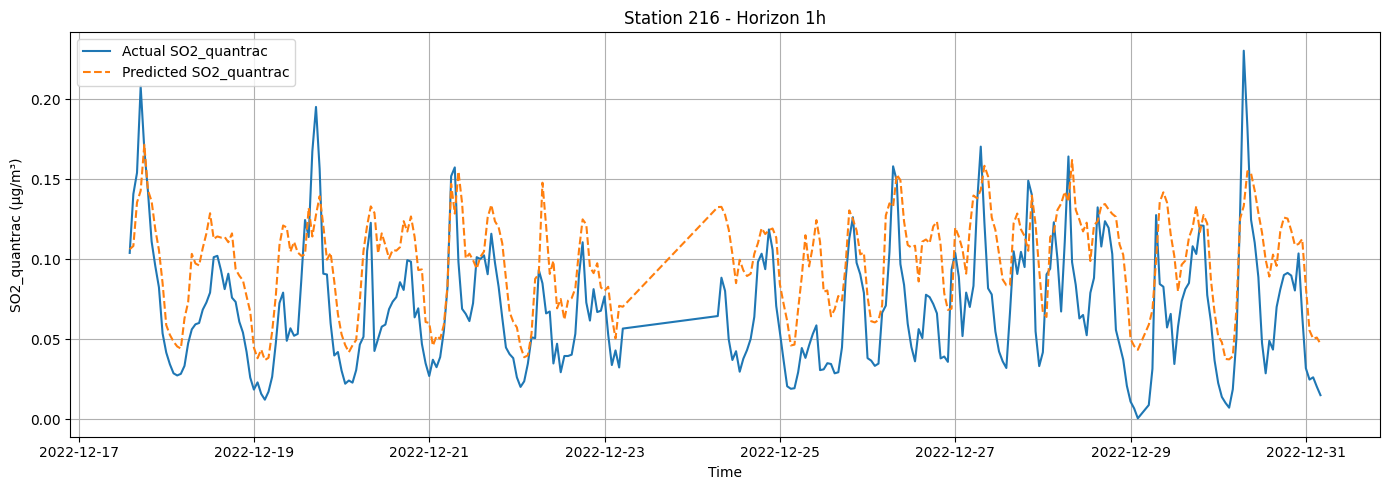

hour = 24


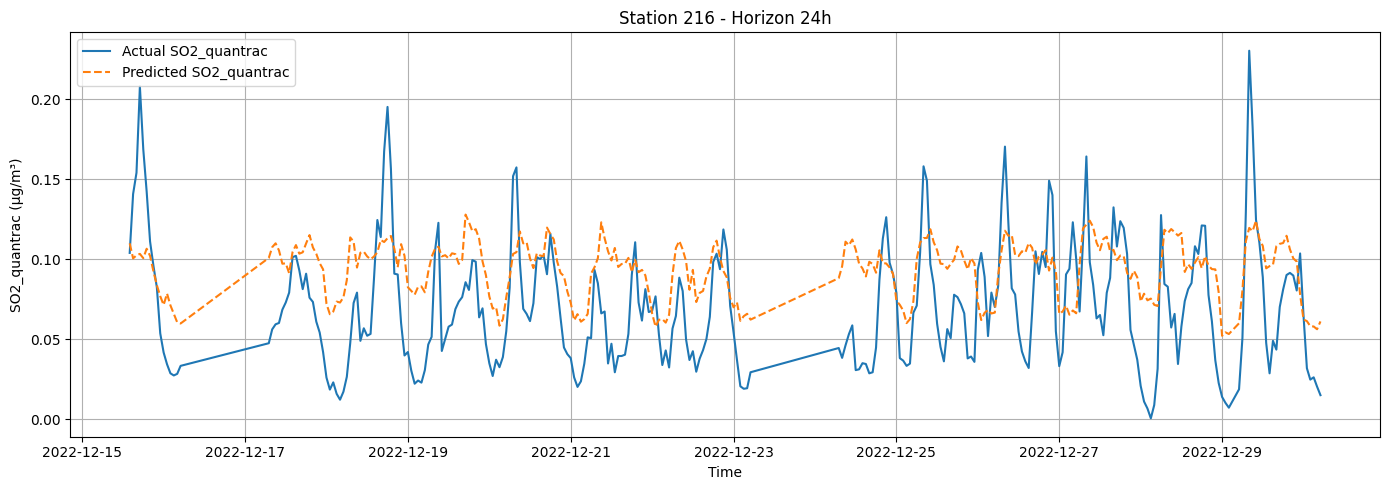

hour = 48


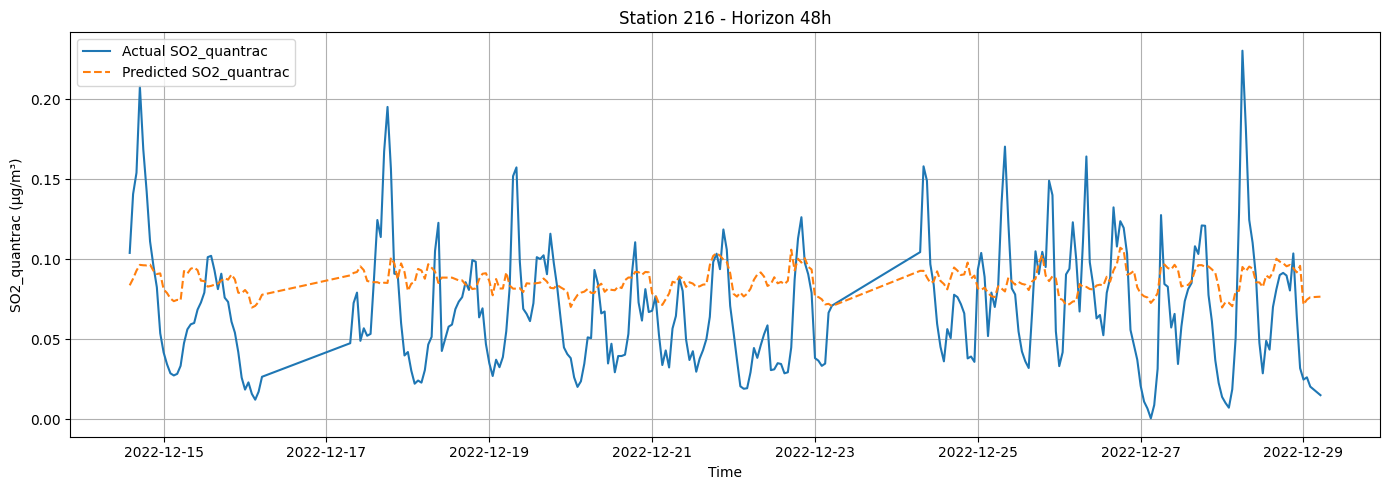

hour = 72


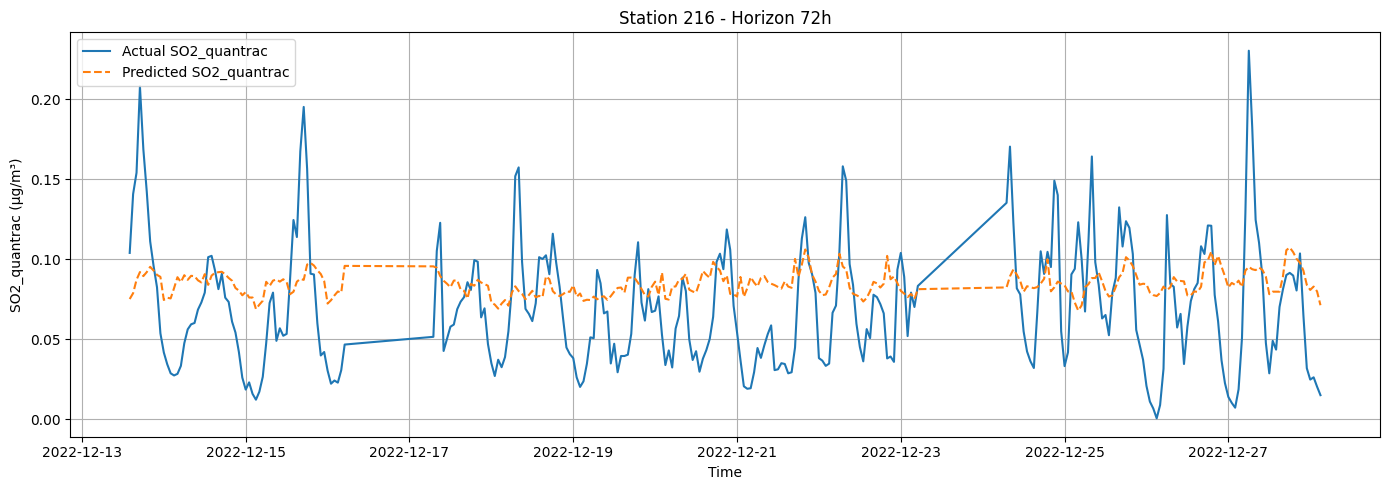

In [19]:
# Reference
for station_id in STATION_IDS:
    print(f"station_id = {station_id}")
    for hour in HORIZONS:
        print(f"hour = {hour}")
        plot_timeseries_example(df_so2, so2_models_by_h[hour], horizon_h=hour, station_id=station_id, target_col=label, LIGHTGBM_DIR=LIGHTGBM_DIR)